In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joypy
import pacmap
import fitsne
import umap
import flowkit as fk

%matplotlib inline

In [2]:
def make_plots(data, sample_ids, titles, marker, k=10000, seed=123):
    """Reduce scatter and fluroescent channel data to 2D for visualization."""

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    umap_reducer = umap.UMAP()
    pacmap_reducer = pacmap.PaCMAP()

    X_fitsne = fitsne.FItSNE(data_scaled)
    X_umap = umap_reducer.fit_transform(data_scaled)
    X_pacmap = pacmap_reducer.fit_transform(data_scaled)
    
    min_max_scaler = MinMaxScaler()
    X_reduceds = [
        min_max_scaler.fit_transform(tmp_x) for tmp_x in [X_fitsne, X_umap, X_pacmap]
    ]
    
    n = len(X_reduceds)
    fig, axes = plt.subplots(n, 3, figsize=(n*3, 9))

    for i, (X_reduced, title) in enumerate(zip(X_reduceds, titles)):
        for j in range(3):
            z = X[marker].iloc[(j*k):(j+1)*k]
            ax = axes[j, i]
            ax.scatter(
                X_reduced[(j*k):(j+1)*k, 0], 
                X_reduced[(j*k):(j+1)*k, 1], 
                s=1, 
                c=z, 
                cmap='jet'
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([-0.1,1.1])
            ax.set_ylim([-0.1,1.1])
            
            if j==0:
                ax.set_title(title, fontsize=14)
            if i==0:
                ax.set_ylabel('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
    
    plt.tight_layout()

In [3]:
base_dir = "data/8_color_data_set"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

In [4]:
session = fk.Session(sample_path)
session.import_flowjo_workspace(wsp_path)

In [5]:
sample_groups = session.get_sample_groups()
sample_groups

['default', 'All Samples', 'DEN']

In [6]:
sample_group = sample_groups[-1]

In [7]:
print(session.get_gate_hierarchy(sample_group, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [8]:
sample_ids = sorted(session.get_group_sample_ids(sample_group))
sample_ids

['101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

In [9]:
session.analyze_samples(sample_group)

#### Processing gates for 3 samples (multiprocessing is enabled - 3 cpus) ####


## Compare marker distributions between CD4+ and CD8+

In [10]:
k = 10_000

dfs_cd4 = session.get_wsp_gated_events(sample_group, gate_name='CD4+')
dfs_cd8 = session.get_wsp_gated_events(sample_group, gate_name='CD8+')

X_cd4 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd4]))
X_cd8 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd8]))

X = pd.concat([X_cd4, X_cd8], axis=1)
X = X.iloc[:, [0,1,3]]
X.columns = ['marker', 'CD4+', 'CD8+']

In [11]:
X

,marker,CD4+,CD8+
0,FSC-A,0.406250,0.705679
1,FSC-A,0.528443,0.728688
2,FSC-A,0.498786,0.506618
3,FSC-A,0.488823,0.699757
4,FSC-A,0.478622,0.481729
...,...,...,...
419995,CD4 PE-Cy7 FLR-A,0.583163,0.268598
419996,CD4 PE-Cy7 FLR-A,0.601869,0.283824
419997,CD4 PE-Cy7 FLR-A,0.535417,0.308814
419998,CD4 PE-Cy7 FLR-A,0.525959,0.275062


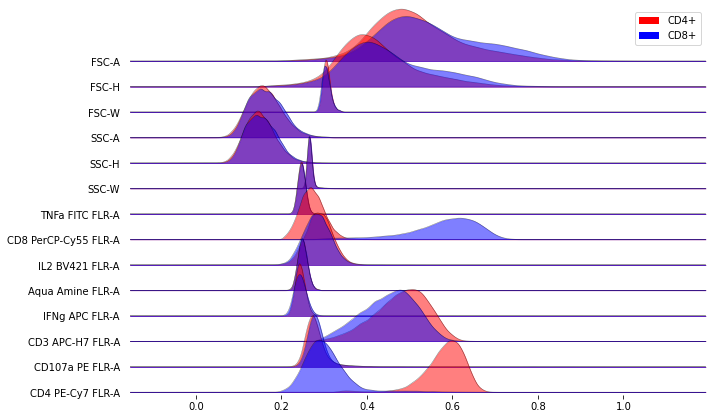

In [12]:
fig, ax = joypy.joyplot(
    X.groupby('marker', sort=False), 
    column=['CD4+', 'CD8+'],
    color=['red', 'blue'],
    legend=True,
    alpha=0.5,
    linewidth=0.5,
    ylim='own',
    figsize=(10, 6)
)

## Visualize dimension reduction schemes for events in Singlet gate

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 30000, K: 90, N*K = 2700000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (16 threads):


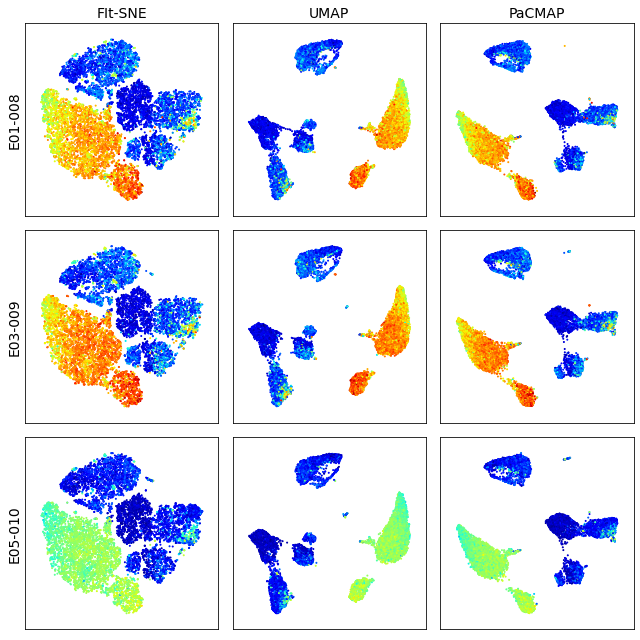

In [13]:
k = 10_000

dfs = session.get_wsp_gated_events(sample_group, gate_name='Singlets')
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)

## Visualize dimension reduction schemes for events in CD3+ gate


Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.004264)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.98 seconds), cost 5.520203
Iteration 100 (50 iterations in 0.91 seconds), cost 5.034818
Iteration 150 (50 iterations in 0.98 seconds), cost 4.914183
Iteration 200 (50 iterations in 0.90 seconds), cost 4.895852
Iteration 250 (50 iterations in 0.90 seconds), cost 4.860172
Unexaggerating Ps by 12.000000
Iteration 300 (50 iterations in 0.89 seconds), cost 3.642594
Iteration 350 (50 iterations in 0.88 seconds), cost 3.194365
Iteration 400 (50 iterations in 1.20 seconds), cost 2.958356
Iteration 450 (50 iterations in 1.78 seconds), cost 2.792736
Iteration 500 (50 iterations in 2.49 seconds), cost 2.704212
Iteration 550 (50 iterations in 3.07 seconds), cost 2.620954
Iteration 600 (50 iterations in 3.63 seconds), cost 2.545234
Iteration 650 (50 iterations in 4.44 seconds), cost 2.5054

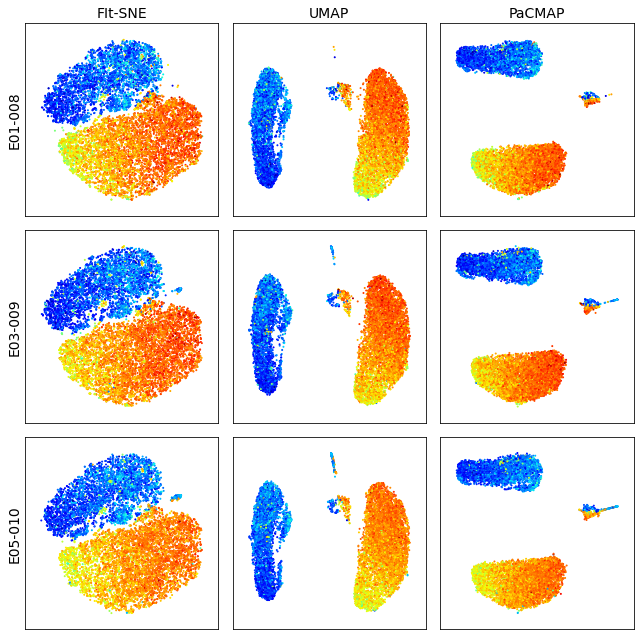

In [14]:
k = 10_000

dfs = session.get_wsp_gated_events(sample_group, gate_name='CD3+')
X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)